# Correcting Detected Fiducial Points in the ECG using Kalman Filtering

In [17]:
%load_ext autoreload
%autoreload 2

import numpy as np

from prominence_delineator import ProminenceDelineator
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load ECG Data

In [18]:
# Load first channel of 7th ECG record from the LUDB database
time, ecg, fs, annotations = load_ecg(record_name="sel100", lead="MLII", filtered=True, left=151000, right=156000)

### Delineate / Detect Waves

In [19]:
# Create an instance of the ProminenceDelineator
PromDelineator = ProminenceDelineator(sampling_frequency=fs)
# Detect the R-peaks in the ECG signal
rpeaks = PromDelineator.find_rpeaks(ecg)
# Clean the ECG signal
ecg = PromDelineator.clean_ecg(ecg)
# Find waves in the ECG signal using the ProminenceDelineator
waves = PromDelineator.find_waves(ecg, rpeaks=rpeaks, include_nodetections=False)

optional: introducing a misdetection (run the following cell to introduce a misdetection and examine its effect on the output | comment out or not run the cell to examine the correction abilities on the detected waves)

In [20]:
# optional: to simulate a misdetection of a T-wave, we are overwriting the waves dictionary with custom values
# waves["T"] = np.array([ 194,  392,  604,  813, 1041, 1199, 1393, 1393, 1821, 1985, 2227,
#        2407, 2603, 2782, 3004, 3179, 3390, 3583, 3786, 4000, 4198, 4374,
#        4567, 4770, 4981])

### Comparing Annotations and Detections
- It is noticeable that the detected R-peak positions match better with the true Peak positions than the annotations
- However, the detected T-waves are not as accurate as the annotations. Especially, the detected T-waves seem a bit inconsistent, i.e., sometimes being minima and maxima (It should be one or the other, since morphologies do not typically change within a recording)

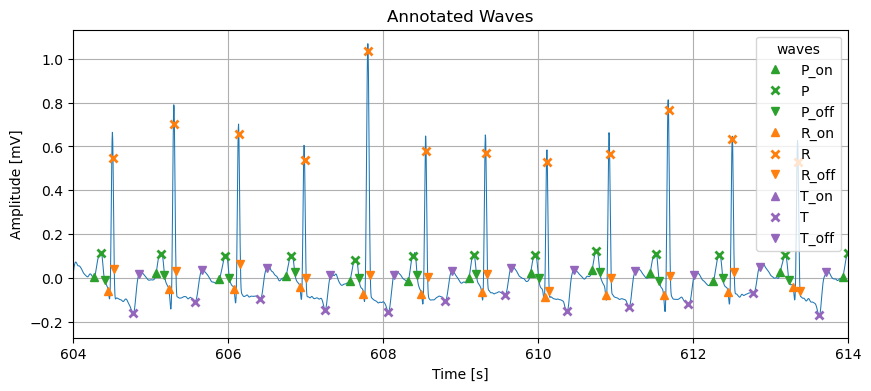

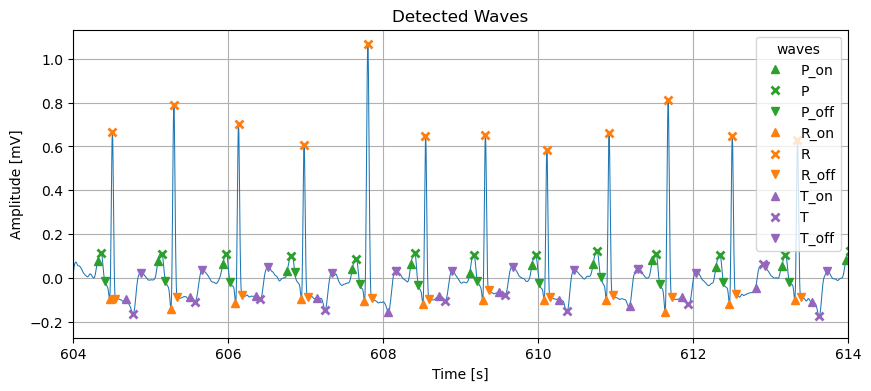

In [21]:
# Plot the annotated ECG signal
plot_waves(time, ecg, annotations, title="Annotated Waves", xlim=[time[0], time[0]+10])
# Plot the detected waves
plot_waves(time, ecg, waves, title="Detected Waves", xlim=[time[0], time[0]+10])

To further illustrate the accuracy, we plot the interbeat intervals obtained from the detected fiducial points on the ECG signal.
- Regarding the detected T-wave, a significantly higher variation can be noticed in comparision to the annotations and other detected waves (e.g. R-peaks)

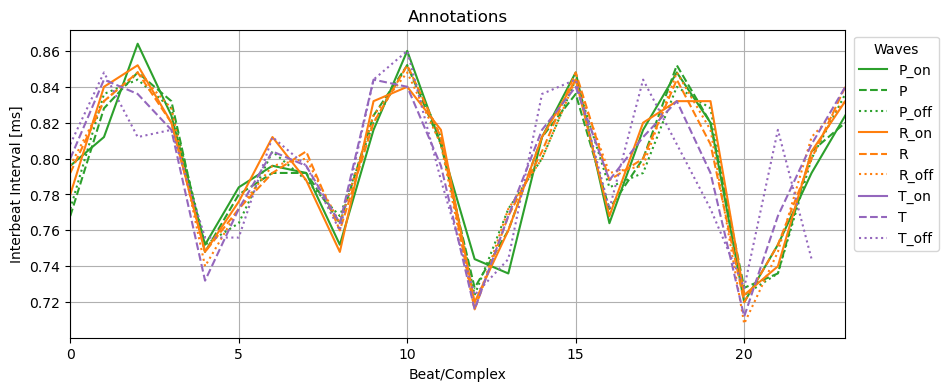

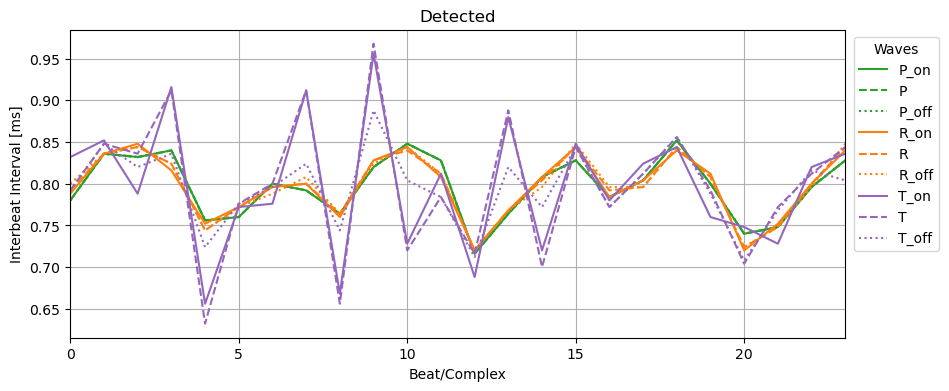

In [22]:
plot_interbeat(annotations, fs, title="Annotations")
plot_interbeat(waves, fs, title="Detected")

## Kalman Filtering


To simplify this example, we will only focus on the wave locations (R-peaks, P-peaks, T-peaks, etc.) and for now, neglect the correction of on-/onset positions.

A basic Kalman Filter is utilized for this task. It estimates the wave positions based on its underlying model and the provided input, i.e., the detected waves. The utilized model assumes a constant velocity, i.e., the wave positions are assumed to move approximately with the same constant velocity. Measurement noise reflects the uncertainty in the detected wave positions, while the process noise represents the mismatch between model and reality (e.g., a constant velocity would assume a constant RR-interval, which is not the case in reality, however is serves as a good approximation for the progressive nature of wave positions).

*TODO: Further tuning of the noise parameters and measurement covariance might also provide further improvements*

In [23]:
from filterpy.stats import plot_covariance_ellipse
from filterpy.common import Q_discrete_white_noise
from filterpy.kalman import KalmanFilter
from scipy.linalg import block_diag

R_std = .4 # measurement noise
Q_std = .6 # process noise

### 1. Basic Kalmanfilter setup
tracker = KalmanFilter(dim_x=4, dim_z=3)
dt = 1   # time step
# state transition matrix
tracker.F = np.array([[1, 0, 0, dt],
                      [0, 1, 0, dt],
                      [0, 0, 1, dt],
                      [0, 0, 0, 1]])
# Measurement function
tracker.H = np.array([[1, 0, 0, 0],
                      [0, 1, 0, 0],
                      [0, 0, 1, 0]])
# Measurement uncertainty
c = 0
tracker.R = np.array([[2, c, c],
                      [c, 1, c],
                      [c, c, 20]]) * R_std**2
#tracker.R = np.cov(M)/np.max(np.cov(M)) * R_std**2
# Process noise
tracker.Q = Q_discrete_white_noise(dim=tracker.dim_x, dt=dt, var=Q_std**2)
# Initial state
tracker.x = np.array([[waves["P"][0], waves["R"][0], waves["T"][0],  0]]).T
# State covariance
tracker.P = np.eye(4) * 50



### 2. Run the Kalman Filter on P, R, T waves
# collect input data for Kalman filtering
zs = np.array([waves["P"], waves["R"], waves["T"]]).T
# run filter
mu, cov, _, _ = tracker.batch_filter(zs)

### Visualize the Kalman Filter output and compare it to the detected waves and the annotations

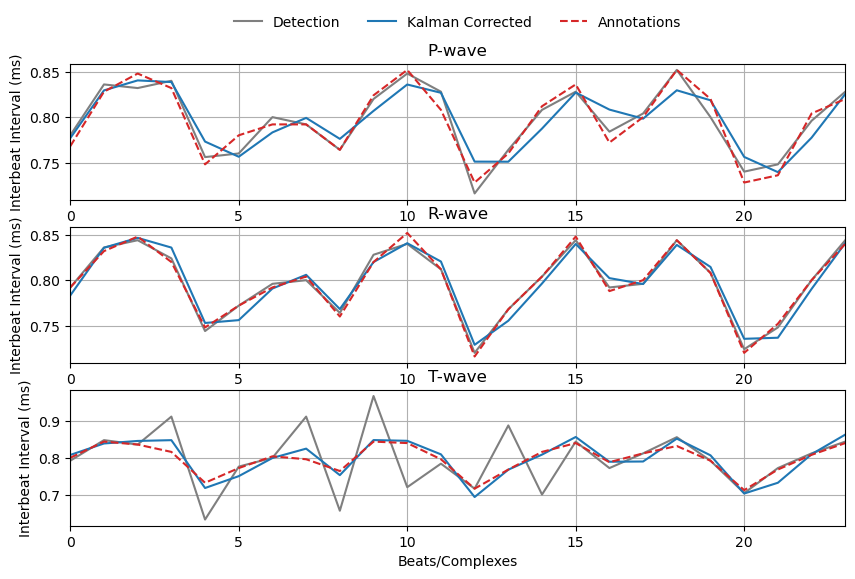

In [24]:
# visualize Kalman tracking
plot_results(zs, mu, annotations, ["P", "R", "T"], fs)       

## Result Comparision

To provide better results an additional post-processing is applied: The detected peaks are corrected towards the nearest maxima/minima. If it corrects towards maxima or minima is determined by the majority type of peaks in the detected waves, e.g., if the majority of detected T-waves are maxima, then the Kalman corrected T-waves moved towards the nearest maxima. In the following, this approach is referenced as "Corrected to majority Extrema" .

### Comparing wave positions in the ECG signal
- The detected waves exhibit inconsistency in the detection of the T-wave peak. Moreover, one T-wave is not detected at all (simulated data). 
- The Kalman filter is detecting / estimating the not detected T-wave correctly, however, the estimated peaks are not as accurate as the detected peaks.
- After correcting the Kalman-filtered waves towards the nearest extrema (either maxima or minima depending on the majority of the detected waves), the obtained waves seem very accurate. Only the T-wave position of the not detected wave is slightly shifted.

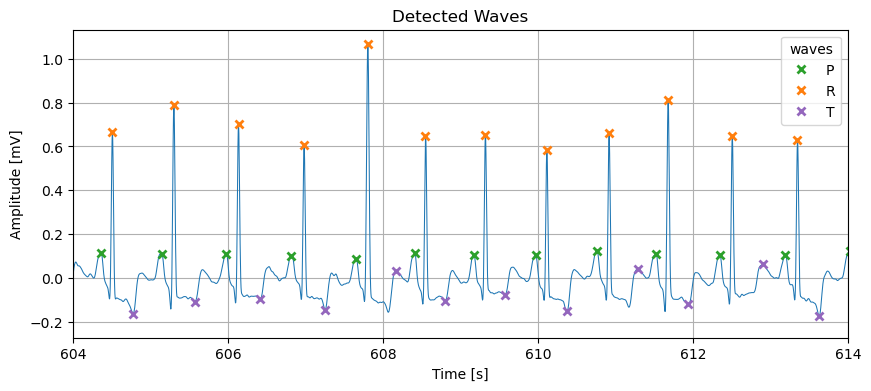

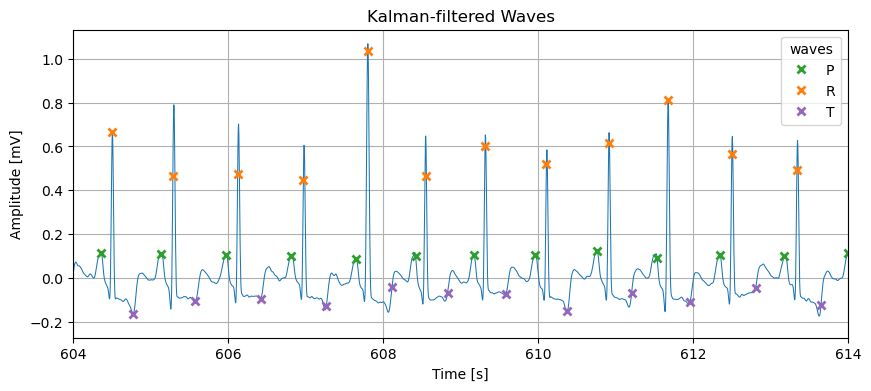

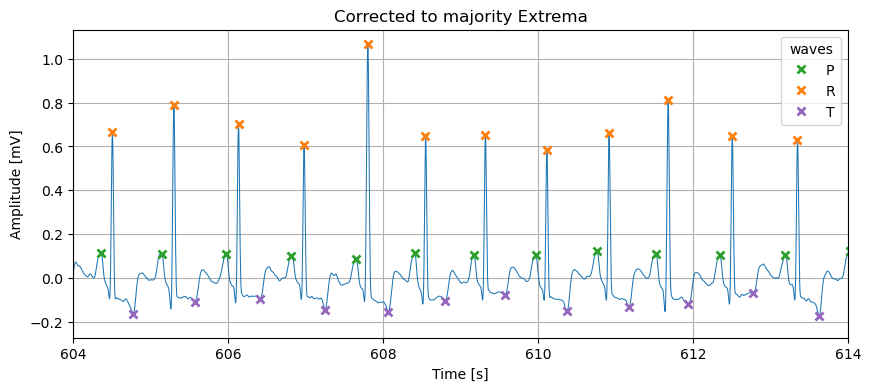

In [25]:
def truncate(arr, n):
    return arr[arr <= n]

N = len(ecg)
corrected_waves = {
    "P": truncate(mu[:, 0, 0], N).astype(int),
    "R": truncate(mu[:, 1, 0], N).astype(int),
    "T": truncate(mu[:, 2, 0], N).astype(int)
    }
detected_waves = dict((k, waves[k]) for k in ("P", "R", "T"))
corrected_majority = correct_waves_to_major_extrema(ecg, corrected_waves, detected_waves)

plot_waves(time, ecg, detected_waves, title="Detected Waves", xlim=[time[0], time[0]+10])
plot_waves(time, ecg, corrected_waves, title="Kalman-filtered Waves", xlim=[time[0], time[0]+10])
plot_waves(time, ecg, corrected_majority, title="Corrected to majority Extrema", xlim=[time[0], time[0]+10])

### Comparing the interbeat intervals to make the differences more visible
- Improvements regarding the T-wave interbeat interval are clearly visible

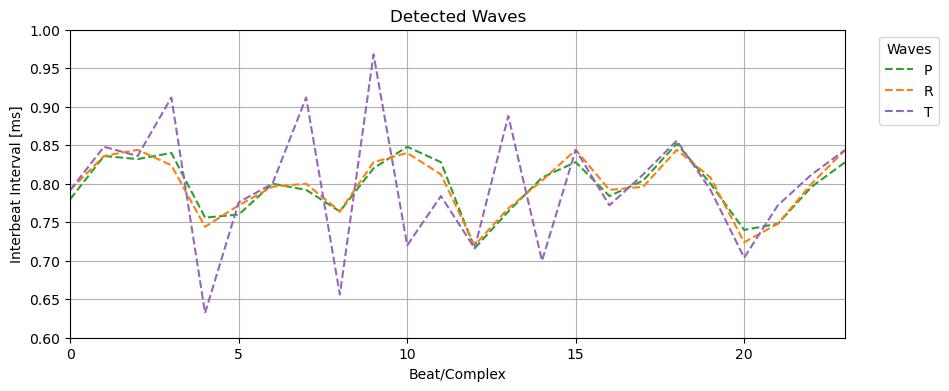

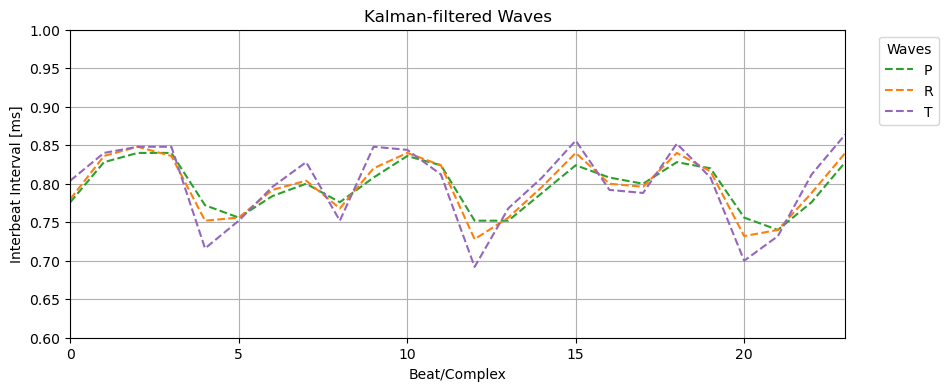

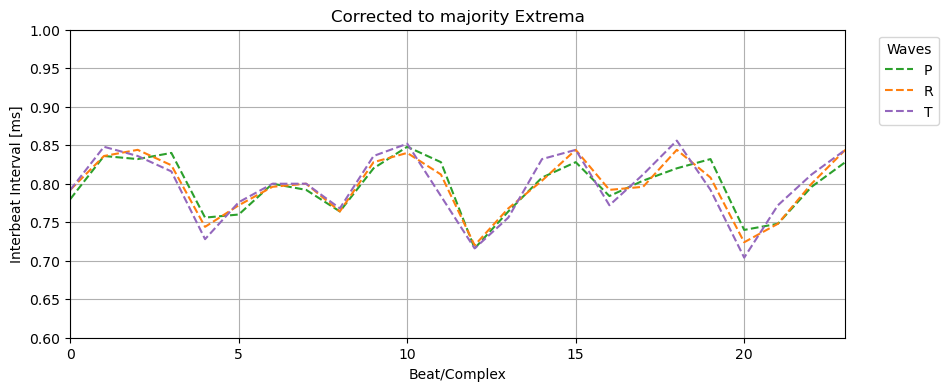

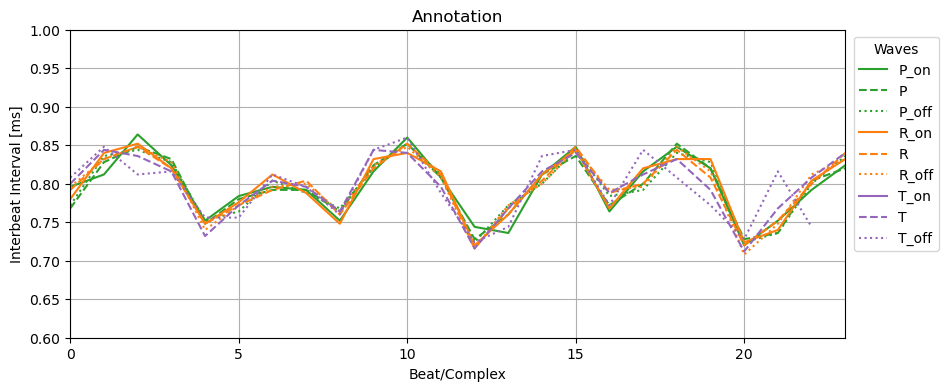

In [26]:
plot_interbeat(detected_waves, fs, title="Detected Waves", ylim=[.6, 1])
plot_interbeat(corrected_waves, fs, title="Kalman-filtered Waves", ylim=[.6, 1])
plot_interbeat(corrected_majority, fs, title="Corrected to majority Extrema", ylim=[.6, 1])
plot_interbeat(annotations, fs, title="Annotation", ylim=[.6, 1])

optionally, we can examine the interbeat intervals on top of each other to see the differences

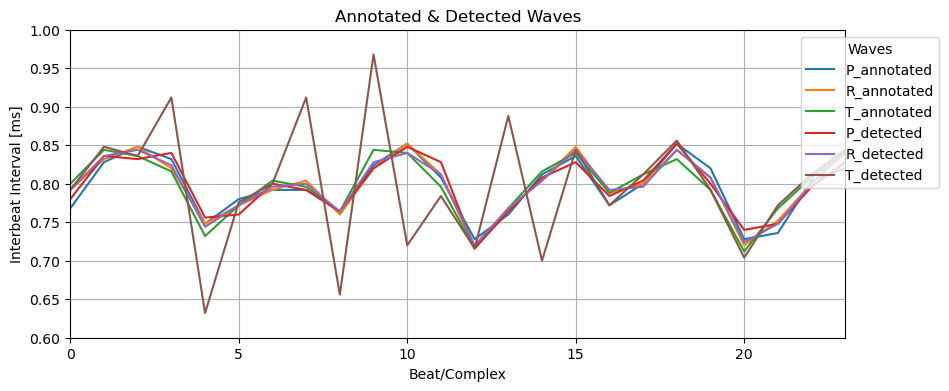

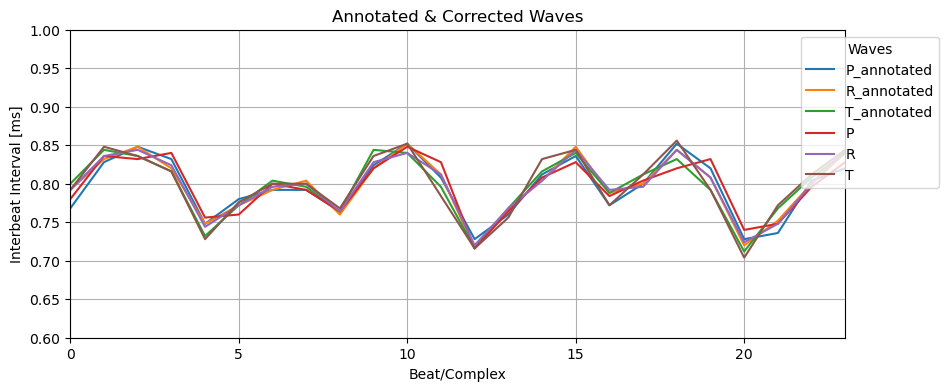

In [27]:
# plot annotated vs. detected waves
mix = {"P_annotated": annotations["P"], "R_annotated": annotations["R"], "T_annotated": annotations["T"], "P_detected": waves["P"], "R_detected": waves["R"], "T_detected": waves["T"]}
plot_dict_as_interbeat(mix, fs, title="Annotated & Detected Waves", ylim=[.6, 1])

# plot corrected vs. detected waves
mix = {"P_annotated": annotations["P"], "R_annotated": annotations["R"], "T_annotated": annotations["T"]}
mix.update(corrected_majority)
plot_dict_as_interbeat(mix, fs, title="Annotated & Corrected Waves", ylim=[.6, 1])